In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

# Gas-phase Kinetics

## Reaction rates and the Arrhenius Equation

Last week we verified that the rate of tBP thermal decomposition varies linearly with tBP concentration, i.e., that the reaction is first-order in tBP. This week, we'll study the dependence of the unimolecular first-order rate constant $k_\infty$ on temperature and test the suitability of the Arrhenius equation as a model for this temperature-dependence. 

The Arrhenius equation <br>
$$ k = A e^{-\frac{E_a}{RT}}$$<br><br>
is an empirical equation that is often found experimentally to quite accurately describe the dependence of reaction rate constants $k$ on temperature $T$. It's important to keep in mind that the Arrhenius Equation is *not* a univeral law. There are some systems for which it works very well and others for which it doesn't. 

Althogh the Arrhenius Equation can be derived theoretically under certain limiting assumptions, the mathematics behind it is a bit complex (unless you happen to be particularly fond of stochastic calculus...). However, the law is not so difficult to "guess" based on physical intuition. The key concept -- one of the foundational assumptions of statistical mechanics -- is that, **at equilibrium, the probability of finding a system in a particular microstate decays exponentially with the energy of that state.** 

## Microstates and Statistical Mechanics

Since some of those terms are likely unfamiliar to you at this point, let's talk through them in more detail. 
* **Statistical Mechanics** is the area of physical chemistry that tries to predict *bulk* properties (e.g., the density, stability, electrical conductivity) from microscopic (atomistic) models.
* A **Microstate** is a particular *microscopic* configuration of a material system, i.e., a configuration in which all the position and momenta of *all* the particles are specified. This is to be distinguished from a **macrostate** (or thermodynamic state) where only a few "macroscopic" properties are known (e.g., pressure, volume, and temperature) and can be used to determine other macroscopic (but not microscopic!) properties. 

In real systems, the *microstate* is constantly changing, even when the system is at *macroscopic* equilibrium. E.g., the macroscopic properties (temperature, pressure, etc.) of a cylinder of O$_2$ gas may not be changing (i.e., the system is in equilibrium), but at the atomic scale individual O$_2$ molecules are whizzing rapidly through space, colliding with each other and with the walls of the cylinder thousands of times each second. 

The **central challenge of statistical mechanics** is to determine how to assign *probabilities* to each of the possible microstates of a system in order to accurately *predict* its macroscopic properties as an average over the individual microstates. 



## The Boltzmann Distribution

The solution to this central challenge comes through the observation -- really a hypothesis -- that (at fixed temperature, volume, and number of particles) the probability that the system occupies any particular microstate (call it $\mu$) decays exponentially with the energy ${\mathcal E}_\mu$ of that state<br><br>
$$p_\mu \propto \exp\left(-\frac{{\mathcal E}_\mu}{k_B T} \right) . $$<br>
The parameter $k_B$ is called the *Boltzmann constant*, and this formula for assigning microstate probabilities is known as the **Boltzmann Distribution**. 

We won't derive the Boltzmann distribution here or even justify it theoretically. But we *can* demonstrate the principle through a simple computational simulation. The app below runs a simple molecular dynamics simulation for a box of charged particles (red = negative, blue = positive) initially at rest in a closed box. The frame at left shows a "movie" of the particles bouncing around in the box. The frame at right plots a histogram (updated each frame) of the number of the *kinetic energy* of each particle. 

Now, strictly speaking, the Boltzmann distribution applies to the *total* energy of a system. But in most cases it turns out to hold separately for kinetic and potential energy; and, for weakly interacting particles, it also holds for each particle individually. That's what the simulation below demonstrates. The **black** line on the histogram shows the exponential Boltzmann distribution predicted by statistical mechanics. Run a simulation with $\sqrt{N} = 6$. (It may take a few minutes to complete the simulation.) Note that within a few ps of simulation time, the histogram has converged to closely match the Boltzmann curve: The kinetic energy is *exponentially distributed* throughout the system. 

In [2]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Javascript, display
from ipywidgets import widgets
import IPython.display as ipd
import time

import numpy as np


In [9]:
def run_sim(b):

    global Eavg, Karr, Xarr, Yarr, L
    
    sqrtN = Nslider.value
    tmax = float(tslider.value)*1e-12

    def calc_accel(x,y):
        ax = 4*epso*(Ro**4)/(M*x**5) - 4*epso*(Ro**4)/(M*(L-x)**5)
        ay = 4*epso*(Ro**4)/(M*y**5) - 4*epso*(Ro**4)/(M*(L-y)**5)

        for p1 in range(0, Npart):
            for p2 in range(0,Npart):
                if p1!=p2:
                    rX = x[p1] - x[p2]
                    rY = y[p1] - y[p2]
                    r = math.sqrt(rX*rX + rY*rY)
                    ax[p1] += Q[p1]*Q[p2]*rX/(M*r**3)
                    ay[p1] += Q[p1]*Q[p2]*rY/(M*r**3)
                    ax[p1] += 12.0*epso*rX*(Ro**12)/(M*r**14) - 12.0*epso*rX*(Ro**6)/(M*r**8)
                    ay[p1] += 12.0*epso*rY*(Ro**12)/(M*r**14) - 12.0*epso*rY*(Ro**6)/(M*r**8)
        return ax,ay

    def calc_energy(x,y, vx, vy):
        Epart = np.zeros((Npart,))
        for p1 in range(0, Npart):
            for p2 in range(0,Npart):
                if p1!=p2:
                    rX = x[p1] - x[p2]
                    rY = y[p1] - y[p2]
                    r = math.sqrt(rX*rX + rY*rY)
                    Epart[p1] += Q[p1]*Q[p2]*rX/(r**2)
                    Epart[p1] += epso*(Ro**12)/(r**12) - 2.0*epso*(Ro**6)/(r**6)

        Epart += 0.5*M*vx*vx + 0.5*M*vy*vy

        return Epart

    def calc_kenergy(x,y, vx, vy):
        return 0.5*M*(vx*vx + vy*vy)

    def vv_step(x,y,vx,vy,ax,ay):
        xnew = x + vx*dt + 0.5*ax*dt*dt
        ynew = y + vy*dt + 0.5*ay*dt*dt
        axnew,aynew = calc_accel(xnew,ynew)
        vxnew = vx + 0.5*(ax + axnew)*dt
        vynew = vy + 0.5*(ay + aynew)*dt
        return xnew,ynew,vxnew,vynew,axnew,aynew


    epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)
    Ro = 5.0e-8

    dt=1e-15            # Time-step in seconds
    Nsteps=int(round(tmax/dt))
    M=4*(1.66054e-24)   # Mass in g
    L=2e-6              # Box length in cm
    V=1e+5              # Velocity (magnitude) in cm/s

    Npos = sqrtN*sqrtN
    Nneg = Npos

    # Total number of particles
    Npart = Npos+Nneg

    # Particle charges
    Qo = 4.803e-10         # Elementary charge in statCoulombs
    Q = np.zeros((Npart))  # Empty vector for particle charges
    Q[0:Npos] = 0.5*Qo    # First Npos particles are positive
    Q[Npos:] = -0.5*Qo     # Last Nneg particles are negative


    dwall = 0.1*L
    xvec = (0.5*L-2.0*dwall)*np.arange(0, sqrtN)/(sqrtN-1)
    yvec = (L-2.0*dwall)*np.arange(0, sqrtN)/(sqrtN-1)

    xmesh,ymesh = np.meshgrid(xvec, yvec)

    X = np.zeros((Npart,))
    Y = np.zeros((Npart,))

    sig = 0.1*(xvec[1]-xvec[0])

    X[0:Npos] = np.reshape(xmesh+dwall, (Npos,)) + np.random.normal(0, sig, (Npos,))
    Y[0:Npos] = np.reshape(ymesh+dwall, (Npos,)) + np.random.normal(0, sig, (Npos,))
    X[Npos:] = np.reshape(xmesh+dwall+0.5*L, (Nneg,)) + np.random.normal(0, sig, (Nneg,))
    Y[Npos:] = np.reshape(ymesh+dwall, (Nneg,)) + np.random.normal(0, sig, (Nneg,))

    V = 0
    # Generate a vector of random velocities
    VX = np.random.normal(0, V, (Npart))
    VY = np.random.normal(0, V, (Npart))

    E0 = calc_energy(X, Y, VX, VY)
    Eavg = np.mean(E0) - np.min(E0)
    KE = calc_kenergy(X, Y, VX, VY)

    # Calculate accelerations at initial positions
    AX,AY = calc_accel(X,Y)

    df = 25
    Nframes = int(Nsteps/df)
    Xarr = np.zeros((Npart,Nframes))
    Yarr = np.zeros((Npart,Nframes))
    Karr = np.zeros((Npart,Nframes))
    f = 0
    for n in range(0,Nsteps):
        X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY)
        if(n%df==0):
            KE = calc_kenergy(X, Y, VX, VY)
            Karr[:,f] = KE
            Xarr[:,f] = X
            Yarr[:,f] = Y
            f += 1
            pbar.value = 100.0*n/Nsteps
            pbar.description = '{:.1f}'.format(100.0*n/Nsteps) + '% Complete'
            

tslider = widgets.IntSlider(
    value=2,
    min=1,
    max=5,
    step=1,
    description='T$_\\text{max}$ (sec):'
)

Nslider = widgets.IntSlider(
    value=3,
    min=3,
    max=7,
    step=1,
    description='$\\sqrt{N}$:'
)

pbar = widgets.FloatProgress(
    value=0.0,
    min=0.0,
    max=100.0,
    description='0% Complete:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style= {'description_width': '3cm'},
    orientation='horizontal'
)

RunBt = widgets.Button(
    description='Run!'
)
RunBt.on_click(run_sim)

display(Nslider)
display(tslider)
display(RunBt)
display(pbar)

IntSlider(value=3, description='$\\sqrt{N}$:', max=7, min=3)

IntSlider(value=2, description='T$_\\text{max}$ (sec):', max=5, min=1)

Button(description='Run!', style=ButtonStyle())

FloatProgress(value=0.0, description='0% Complete:', style=ProgressStyle(description_width='3cm'))

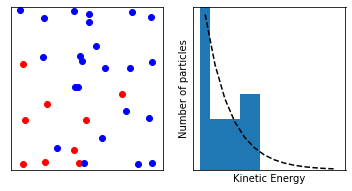

In [10]:
def plot_sim(b):

    def update_plot(X, Y, KE):

        ppts.set_xdata(X[0:Npos])
        ppts.set_ydata(Y[0:Npos])

        npts.set_xdata(X[Npos:])
        npts.set_ydata(Y[Npos:])

        hst = np.histogram(KE, kbins)[0]
        #hpts.set_ydata(hst)
        for n in range(0, len(hst)):
            hrects[n].set_height(hst[n]/Npart)

        fig.canvas.draw()
        display(plt.gcf())
        ipd.clear_output(wait=True)

    Npos = Nslider.value**2
    Npart = 2*Npos

    Nbins = 15
    Npts = 50
    Eaxis = np.arange(0, Npts)*6*0.3*Eavg/Npts
    kbins = np.arange(0, Nbins)*Eaxis[-1]/Nbins
    pdist = np.exp(-(kbins[1:]-0.5*kbins[1])/(0.3*Eavg))
    pdist /= 0.95*np.sum(pdist)

    fig = plt.figure(figsize=(6,3))
    ax1 = plt.subplot(1,2,1)
    ppts, = plt.plot(Xarr[0:Npos,0],Yarr[0:Npos,0],'ro')
    npts, = plt.plot(Xarr[Npos:,0],Yarr[Npos:,0],'bo')
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([]) 
    plt.yticks([]) 

    ax2 = plt.subplot(1,2,2)
    #hpts, = plt.plot(kbins[:-1]+0.5*kbins[0], 0*kbins[:-1], 'o-')
    hrects = plt.bar(kbins[:-1]+0.5*kbins[0], 0*kbins[:-1], width=kbins[1])
    plt.plot(kbins[:-1]+0.5*kbins[0], pdist, 'k--')
    
    plt.xlabel('Kinetic Energy')
    plt.ylabel('Number of particles')
    plt.yticks([])
    plt.xticks([])

    Nframes = np.shape(Xarr)[1]
    for f in range(0, Nframes):
        update_plot(Xarr[:,f], Yarr[:,f], Karr[:,f])
        time.sleep(0.01)    

    display(pltBT)
    
pltBT = widgets.Button(
    description='Play Simulation'
)
pltBT.on_click(plot_sim)
display(pltBT)

In [1]:
# from IPython.display import display_markdown
# import ipywidgets as widgets
# from ipywidgets import Layout

# def make_title_font(text):
#     text = '<span style="font-size:large; font-weight:bold">' + text + '</span>'
#     return text

# def make_def_box(topic, shortdef, longdef):
#     #Head = widgets.Output()
#     Body = widgets.Output()
#     Accord = widgets.Accordion(children=[Body], selected_index=None)
#     Accord.set_title(0, shortdef)
    
# #     with Head:
# #         display_markdown(make_title_font(topic) + ":", raw=True)
        
#     with Body:
#         display_markdown(longdef, raw=True)
        
#     #return widgets.VBox([Head, Accord])
#     return widgets.VBox([Accord])


# TempBoxes = []

# TempBoxes.append(make_def_box('Thermal Activation', 
#      'Thermal Activation', 
#      'Although the final products of tBP decomposition are lower in energy\
#      than tBP itself, breaking a stable bond *always* requires some initial\
#      energy input to break the starting molecular configuration. In thermal \
#      decomposition, this initial energy is provided by random molecular collisions. \
#      As originally formulated by Lindemann, the formal mechanism for tBP decomposition \
#      can be thought of as initiating with a molecular collision of the form<br><br>\
#      $$ \\text{tBP} + \\text{M} \\xrightarrow{k_1} \\text{tBP}^* + \\text{M}.$$<br>\
#      Here \"M\" can be any molecular species in the gas phase that can collide with \
#      tBP and impart thermal energy to it (a process called \"activation\". The reaction \
#      proceeds at a rate that is  proportional to the concentration of tBP and the \
#      concentration of M, with a proportionality constant $k_1$. Once activated, the \
#      excited molecule (tBP$^*$) can do one of two things: It can experience a \
#      *deactivating* collision, giving its internal energy back to the bath<br><br>\
#      $$ \\text{tBP}^* + \\text{M} \\xrightarrow{k_{-1}} \\text{tBP} + \\text{M}$$<br>\
#      *or* it can decompose:<br><br>\
#      $$\\text{tBP}^* \\xrightarrow{k_2} 2 (\\text{CH}_3)_3\\text{CO}^\\bullet.$$<br>\
#      In your experiments, you\'ll monitor the rate $-\\frac{d [\\text{tBP}]}{dt}$ \
#      at which the concentration of tBP changes. According to the rate law above, \
#      this instantaneous rate  is proportional to the concentration of the thermally \
#      activated species tBP$^*$:<br><br>\
#      $$ -\\frac{d [\\text{tBP}]}{dt} = k_2 [ \\text{tBP}^*] . $$\
#      <br>'))

# for box in TempBoxes:
#     display(box)

## Application to tBP Decomposition ##

With this result in mind, let's think about how this result might apply to tBP decomposition. Last week we said that tBP decomposition begins with the spontaneous fragmentation of a *thermally excited* tBP molecule (tBP$^*$):
$$\text{tBP}^* \xrightarrow{k_2} 2 (\text{CH}_3)_3 \text{CO}^\bullet.$$<br>

In our last lecture, we went through a rather complicated derivation to convert this fundamental rate constant $k_2$ to an *effective* rate constant $k_\infty$ that accounts for the fraction of tBP that is thermally excited. Now, our question is: How should this effective rate constant $k_\infty$ vary with temperature? 

The Boltzmann principle suggests a simple answer. $k_\infty$ is proportional to the *fraction* of tBP molecules that have enough internal energy to spontaneously decompose. Suppose the minimum energy required for a tBP molecule to decompose is ${\mathcal E}_\text{dissoc}$. So long as the rate constant $k_2$ for decomposition is small enough that the tBP population stays close to equilibrium throughout the experiment (this is the steady-state assumption we made last week), the Boltzmann distribution says that the probability that a molecule possesses this dissociation energy is <br><br>
$$ p_\text{dissoc} \propto \exp \left ( - \frac{{\mathcal E}_\text{dissoc}}{k_B T} \right).$$<br>
Thus, intuitively we should expect $k_\infty$ to take a form something like 
$$k_\infty \propto p_\text{dissoc} k_2 = k_2 \exp \left ( - \frac{{\mathcal E}_\text{dissoc}}{k_B T} \right).$$
But this is exactly the exponential form of the Arrhenius law! 

The only two differences between this last expression and the standard Arrhenius form<br>
$$ k = A \exp \left( -\frac{E_a}{RT} \right)$$
is that 
1. Our simple expression accounts only for decomposition through one particular microstate $\mu$, whereas the real rate constant should be averaged over all possible microstates that have energies greater than ${\mathcal E}_\text{dissoc}$. Thus the Arrhenius law prefactor $A$ is a rather complicated average over the intrinsic rate constants $k_\text{2}$ corresponding to many different possible predissociative microstates $\mu$. 

2. We have written our expression in terms of the *energy per molecule* ${\mathcal E}_\text{dissoc}$, whereas the Arrhenius law is usually written in terms of an activation energy $E_\text{a}$ *per mole*. This is why the denominator of the Arrhenius law contains the the ideal gas constant $R$ instead of the Boltzmann constant $k_B$: The two constants are connected simply by scaling by Avogadro's number:<br>
$$ R = N_\text{A} k_B . $$

## Limitations ##

While the Arrhenius law is thus easy to justify physically, it doesn't always hold true. In contrast to the Boltzmann distribution law (which has so far been found to be essentially universally valid for constant-temperature, constant-volume systems), the Arrhenius law can break down for a variety of reasons. In many systems, multiple reaction paths are possible, with varying activation energies. At low temperatures only one such pathway may be active, but as the temperature increases other pathways begin to contribute to the reaction dynamics as well, leading to deviations from simple exponential behavior. 

## Your Assignment:

In this week's lab, you'll experimentally test the validity of the Arrhenius law to tBP decomposition. Your experimental procedure will be almost identical to what you did last week, except that you'll vary the *temperature* of the reaction with a fixed injection volume. From each time series, you'll extract a first-order rate constant and then examine the variation of that rate constant with temperature to see if it agrees with the Arrhenius law prediction. 
<br><a href="Part2.ipynb"> <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning" style="width:100px; background-color:#E9E9E9; font-size:10pt; color:black">Go!</button></a>


When you're done with your experimental procedure, open the analysis notebook below to record and analyze your results. 

In [3]:
import ipywidgets as widgets
import os
from IPython.display import display
from IPython.display import display_markdown

HTMLButtonPrompt = '''<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
</head>
<body>
<a href="{link}" target="_blank" >
<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning" style="width:100px; background-color:#E9E9E9; font-size:10pt; color:black">{text}</button>
</a>
</body>
</html>
'''


HTMLDeadPrompt = '''<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
</head>
<body>
<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning" style="width:100px; background-color:#E9E9E9; font-size:10pt; color:#D2D2D2">{text}</button>
</body>
</html>'''



def copy_exercise(self):
    uname = txt_uname.value.replace(" ", "_").lower()
    fpath = "../../../../local/"
    flist = ['analysis_2.ipynb', 'Ptrace.csv']
    
    cpname = "Kinetics_2_" + uname + ".ipynb"

    if len(uname)<=0:
        print('Please enter a valid user name!')
        
    elif os.path.isfile(fpath+cpname) and cb_overwrite.value==False:
        message_box.value = 'The file already exists! Click \"Open\" to access.<br> \
        If you want to delete the file and start fresh, you\'ll need to: <br>  \
           (1) open the file, <br> \
           (2) Click \"Edit App\" in the top-right corner,<br>\
           (3) Click the File > Open dropdown, and <br> \
           (4) Manually delete the file using the file browser. <br> \
        Then you can return to this page to copy it again. <br> \
        <b>But be careful!</b> This will also delete any data that you\'ve stored in the notebook!'
        bt_open.value=HTMLButtonPrompt.format(link=fpath+cpname, text='Open')
        
    else:
        err = False
        
        for fname in flist:
            
            # If it's the first file, reset the file name
            if fname==flist[0]:
                out = !{"cp " + fname + " " + fpath+cpname}
                if len(out)>0:
                    for line in out:
                        err = True
                        print(out)
            else:
                
                # If it's an image file, make sure the img folder exists
                if fname[0:4]=='img/':
                    if os.path.isdir(fpath+'/img')==False:
                        out = !{'mkdir ' + fpath + '/img'}
                        if len(out)>0:
                            err = True
                            for line in out:
                                print(out)
                                
                # Now copy the file
                out = !{"cp " + fname + " " + fpath+fname}
                if len(out)>0:
                    for line in out:
                        err = True
                        print(out)
                
        if err==False:
            bt_open.value=HTMLButtonPrompt.format(link=fpath+cpname, text='Open')
    
txt_uname = widgets.Text(
    value='',
    placeholder='User name',
    description='Purdue ID:',
    disabled=False
)


bt_genfile = widgets.Button(
    description='Copy Exercise',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Enter your username and then click to create a local exercise file'
)

bt_open = widgets.HTML(HTMLDeadPrompt.format(text='Open'))

cb_overwrite = widgets.Checkbox(
    value=False,
    description='Overwrite Existing?',
    disabled=False
)

bt_genfile.on_click(copy_exercise)

message_box = widgets.HTML('')

display(widgets.HBox([txt_uname, bt_genfile, bt_open]))
display(message_box)


HTML(value='')

["cp: cannot stat `analysis_b.ipynb': No such file or directory"]
